# Using The Statistic

In [2]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stat_df = pd.read_csv('new csv files/stat_df.csv')
maps = pd.read_csv('original csv files/match_map_stats_000000000000.csv')

maps = maps.rename(columns={"match_winner": "match_winner_team", "map_winner": "map_winner_team"})

In [3]:
stat_df = pd.merge(stat_df, maps, on=['match_id', 'map_name'])
stat_df = stat_df.drop_duplicates(subset=['match_id', 'map_name', 'player', 'Eliminations'])

vals = stat_df.stage.unique().tolist()
playoffs = []
for i in vals:
    valid = ['Title', 'Playoffs', 'Championship', 'Postseason', 'Summer', 'Countdown', 'May', 'June']
    for j in valid:
        if j in i and not('Knockouts' in i or 'Qualifiers' in i):
            playoffs.append(i)

In [4]:
import plotly.express as px

winston_summary = stat_df[stat_df['hero_Winston'] == 1].groupby(['stage', 'player'])['Stat'].describe()[['count', 'mean']].reset_index()
#winston = winston[winston['count'] > 0].sort_values(by='mean')
winston = stat_df[(stat_df['hero_Winston'] == 1)]
winston = pd.merge(winston, winston_summary, on='player')
winston = winston[winston['count'] > 40]

fig = px.bar(winston, x=winston.player, y=winston['mean'], color=winston['stage_x'])
fig.show()
winston

KeyError: 'hero_Winston'

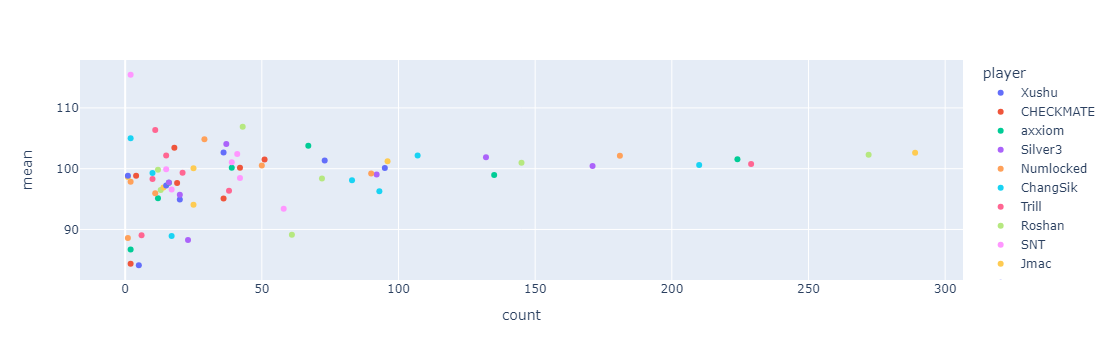

In [159]:
fig2 = px.scatter(winston, x=winston['count'], y=winston['mean'], color=winston['player'])
fig2.show()

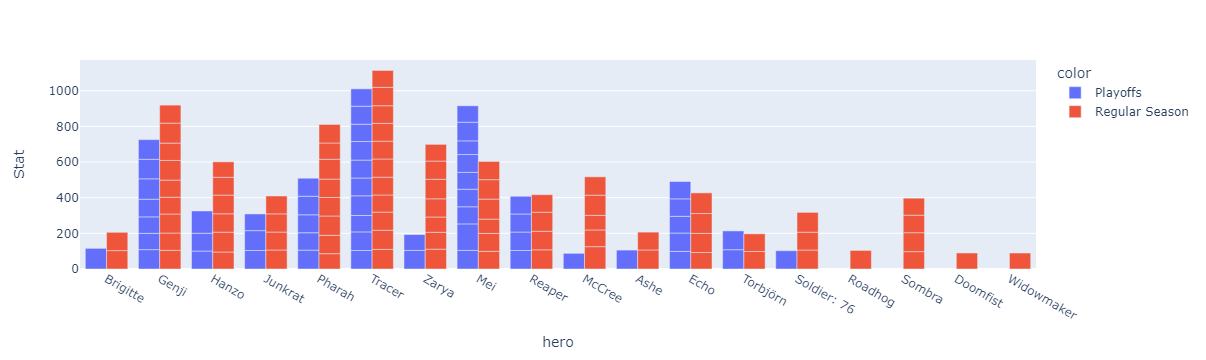

In [223]:
import plotly.express as px
#.groupby('match_id')['Stat'].mean().reset_index()

profit = stat_df
profit = profit[profit['player'] == 'Profit']
profit = profit.groupby(['stage', 'hero'])['Stat'].mean().reset_index()
color=np.array(['Regular Season']*profit.Stat.shape[0])
for i in playoffs:
    color[profit.stage==i] = 'Playoffs'

fig = px.bar(profit, x=profit.hero, y=profit.Stat, color=color, barmode='group')
fig.show()

In [5]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)
cur = pd.DataFrame()

app.layout = html.Div([
    html.H4('Average Stat by Player, Hero, and Stage'),
    dcc.Dropdown(
        id="dropdown",
        options=stat_df.player.unique(),
        clearable=False,
    ),
    dcc.Dropdown(
        id="dropdown2",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("dropdown2", "options"),
    Input("dropdown", "value"))

def set_hero_options(player):
    cur = stat_df[stat_df['player'] == player]
    vals = ['All']
    vals.extend(cur.hero.unique())
    return vals

@app.callback(
    Output("dropdown2", "value"),
    Input("dropdown2", "options"))

def set_hero_value(heroes):
    return 'All'


@app.callback(
    Output("graph", "figure"),
    Input("dropdown", "value"),
    Input("dropdown2", "value"))


def update_bar_chart(player, hero):
    cur = stat_df[stat_df['player'] == player]
    if hero != 'All':
        cur = cur[cur['hero'] == hero] 
    cur = cur.groupby(['stage'])['Stat'].mean().reset_index()
    fig = px.bar(cur, x="stage", y="Stat", barmode='group')
    return fig


app.run_server(debug=True)